# SC3000 Lab Assignment 1

**Lab Group: A37**

**Done by: Ma Wenyue,<br>
Ng Wan Jing** and <br> 
**Chew Zhi Yi Mark**

Contribution:

Wenyue - Coding and Training of Agent

Wan Jing - Researching of RL Agent and Charting Out Results

Mark - Documentation and Tuning Model Parameters

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing dependencies and defining helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import pickle

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Loading the CartPole environment

In [ ]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [ ]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [ ]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.04812601 -0.03076429  0.04100672  0.02435438]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.04751073 -0.2264496   0.0414938   0.32968816]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [ ]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


## Task 1: Development of an RL agent

We decided to create a RL agent using the Q-Learning Algorithm which uses a Q-table to find the best action to take at a given state.

In [ ]:
# Since the environment is affected by the cart position, cart velocity, pole angle and pole angular velcocity
# the cart can move left and right
# reward is basically the time step so no need to define

# Here we define the Q-table which depends on the size of observation_space and action_space with values initiated with uniformly 
# random values between -0.05 and 0.05



# custom size for Observation and interval size for each observation space
observations = [30,30,50,50]
interval_size = np.array([0.25, 0.25, 0.01, 0.1])

# create dem new Qtable
def Qtable(action_space, observation_space):
    q_Table = np.random.uniform(low=0, high=1, size=(observations + [env.action_space.n])) 
    return q_Table

# method to get the discrete state

def discrete_state(state):
    ds = state/interval_size + np.array([15,10,1,10])
    return tuple(ds.astype(int))



# main algo for Q-learning

def QLearning(q_table, episodes, gamma, lr, epsilon):
    
  #initialise values for rewards and epsilon decays
  decay = epsilon / ((episodes // 2) - 1)
  rewards = 0
  # update the Q-table for each episode
    
  for epi in range(1, episodes+1):
      current_state = discrete_state(env.reset())
      score = 0
      gameOver = False
      while not gameOver:
          # exploration vs exploitation choice here
          if np.random.uniform(0,1) < epsilon:
              action  = env.action_space.sample()
          else:
              action = np.argmax(q_table[current_state])
          # to get the next state after the current action     
          observation, reward, gameOver, _ = env.step(action)
          next_state = discrete_state(observation)
          # add the reward for getting to this state
          score+=reward

          # update the Q-table if the the cart is still on top      
          if not gameOver:
            # update the table using the Q-Learning equation with reference from
            # https://medium.com/analytics-vidhya/q-learning-is-the-most-basic-form-of-reinforcement-learning-which-doesnt-take-advantage-of-any-8944e02570c5#:~:text=A%20CartPole%2Dv0%20is%20a,if%20the%20pole%20remains%20upright.
              ultimate_big_max_q = np.max(q_table[next_state])
              current_q = q_table[current_state+(action,)]
              new_q = (1-lr)*current_q + lr*(reward + gamma*ultimate_big_max_q)
              q_table[current_state+(action,)] = new_q

          # move to the next state
          current_state = next_state
      else:
        #check the score while training 
        rewards += score
        # update epsilon value after every run to move slowly towards exploitation
      if (episodes//2) >= epi >= 1:
        epsilon -= decay
      if epi % 1000 == 0:
        print("reward:" , score)
  return q_table              

# Function used to load Qtable

def load_Qtable(Q_NAME, q_table=None):
  try:
    with open(Q_NAME, 'rb') as f:
      return pickle.load(f)
  except:
    Q_table = q_table
    with open(Q_NAME, 'wb') as f:
      pickle.dump(Q_table, f)
      return Q_table


# RL Agent using the Q-table to get the best next action        
def Qlearning_agent(q_table, state):
    return np.argmax(q_table[discrete_state(state)])

We decided to try it out by training our agent with 2000 episodes.

reward: 21.0
reward: 37.0
Observation: [ 0.0006902  -0.04657241 -0.03285584  0.01900607]
Chosen action: 0


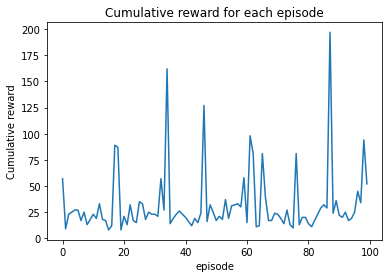

In [ ]:
observation = env.reset()
#Creating the q_table
q_table = Qtable(env.action_space, observations)
#Training the Qlearning Agent
q_table = QLearning(q_table, 2000, 0.95, 0.1, 0.95)
action = Qlearning_agent(q_table, observation)
print("Observation:", observation)
print("Chosen action:", action)


def play(q_table):
  episode_results = []
  for x in range(0,100):

    observation = env.reset()
    cumulative_reward = 0
    done = False
    while not done:
        action = Qlearning_agent(q_table, observation)
        observation, reward, done, info = env.step(action)
        cumulative_reward += reward
    episode_results.append(cumulative_reward)
  return episode_results




episode_results = np.array(play(q_table))
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

However, when we did Task 2, we found out that the model was not good enough to achieve the required reward of 195 as shown below. Hence we decided to increase the episodes to 60000 to ensure that our model is sufficiently trained.

In [ ]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 31.84
Is my agent good enough? False


For Task 1, we can show the observation and chosen action below:

In [ ]:
observation = env.reset()
#Creating the q_table
q_table = Qtable(env.action_space, observations)
#Training the Qlearning Agent

# no need to retrain since we already saved the Qtable from previous run

#q_table = QLearning(q_table, 60000, 0.95, 0.1, 0.3)


tryhard = load_Qtable('tryhard')
action = Qlearning_agent(tryhard, observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [-0.03154674  0.0444556   0.04894982  0.04979045]
Chosen action: 1


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, we used the RL agent we developed in Task 1 which we've trained for 60000 episodes to play the game for 100 episodes, and recorded the cumulative reward for each round, and plotted the reward for each round. 

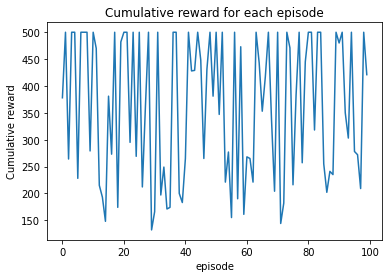

In [ ]:
# Play method to play through 100 episodes with the RL agent

episode_results = np.array(play(tryhard))
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Below is the average reward over the 100 episodes. As can be seen, our model is now sufficiently trained.

In [ ]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 362.38
Is my agent good enough? True


## Task 3: Render one episode played by the agent

We plugged in our Q Learning agent and got the results as shown below.

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = Qlearning_agent(tryhard, observation)
    observation, reward, done, info = env.step(action) 
    if done: 
      break;    
env.close()
show_video()